In [1]:
from PBSHM_mdof.data.noise_manipulator import generate_noise
import numpy as np
import matplotlib.pyplot as plt
from PBSHM_mdof.data.process_data import compute_PSD
from PBSHM_mdof.data.data_handler import HDF5DataBuilder
from config import settings
from pathlib import Path
import h5py
from tqdm import tqdm
from pathlib import Path


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 20

In [3]:
# Load the data and compute the RMS of the signal
path_generated_dataset = Path(settings.default['path']['abspath']) / Path(settings.default['path']['generated_dataset'])

RMS_list = []
with h5py.File(path_generated_dataset, 'r') as input_file:
    dh = HDF5DataBuilder(input_file)
    dt = dh.get_simulation_dt('POPULATION_1', 'default_simulation')
    iterator = dh.get_data_iterator()
    for d in tqdm(iterator):
        tdd = d['TDD']

        for k, v in tdd.items():
            acc_7 = v[:, 2 * 8 + 1]

            system_name = k
            anomaly_level = d['experiment_params']['anomaly_level']
            state = d['experiment_params']['state']
            latent_value = d['experiment_params']['latent_value']
            fr = d['resonance_frequency_data'][k]
            rms = np.sqrt(np.mean(acc_7**2))
            RMS_list.append(rms)
            


2600it [01:03, 41.16it/s]


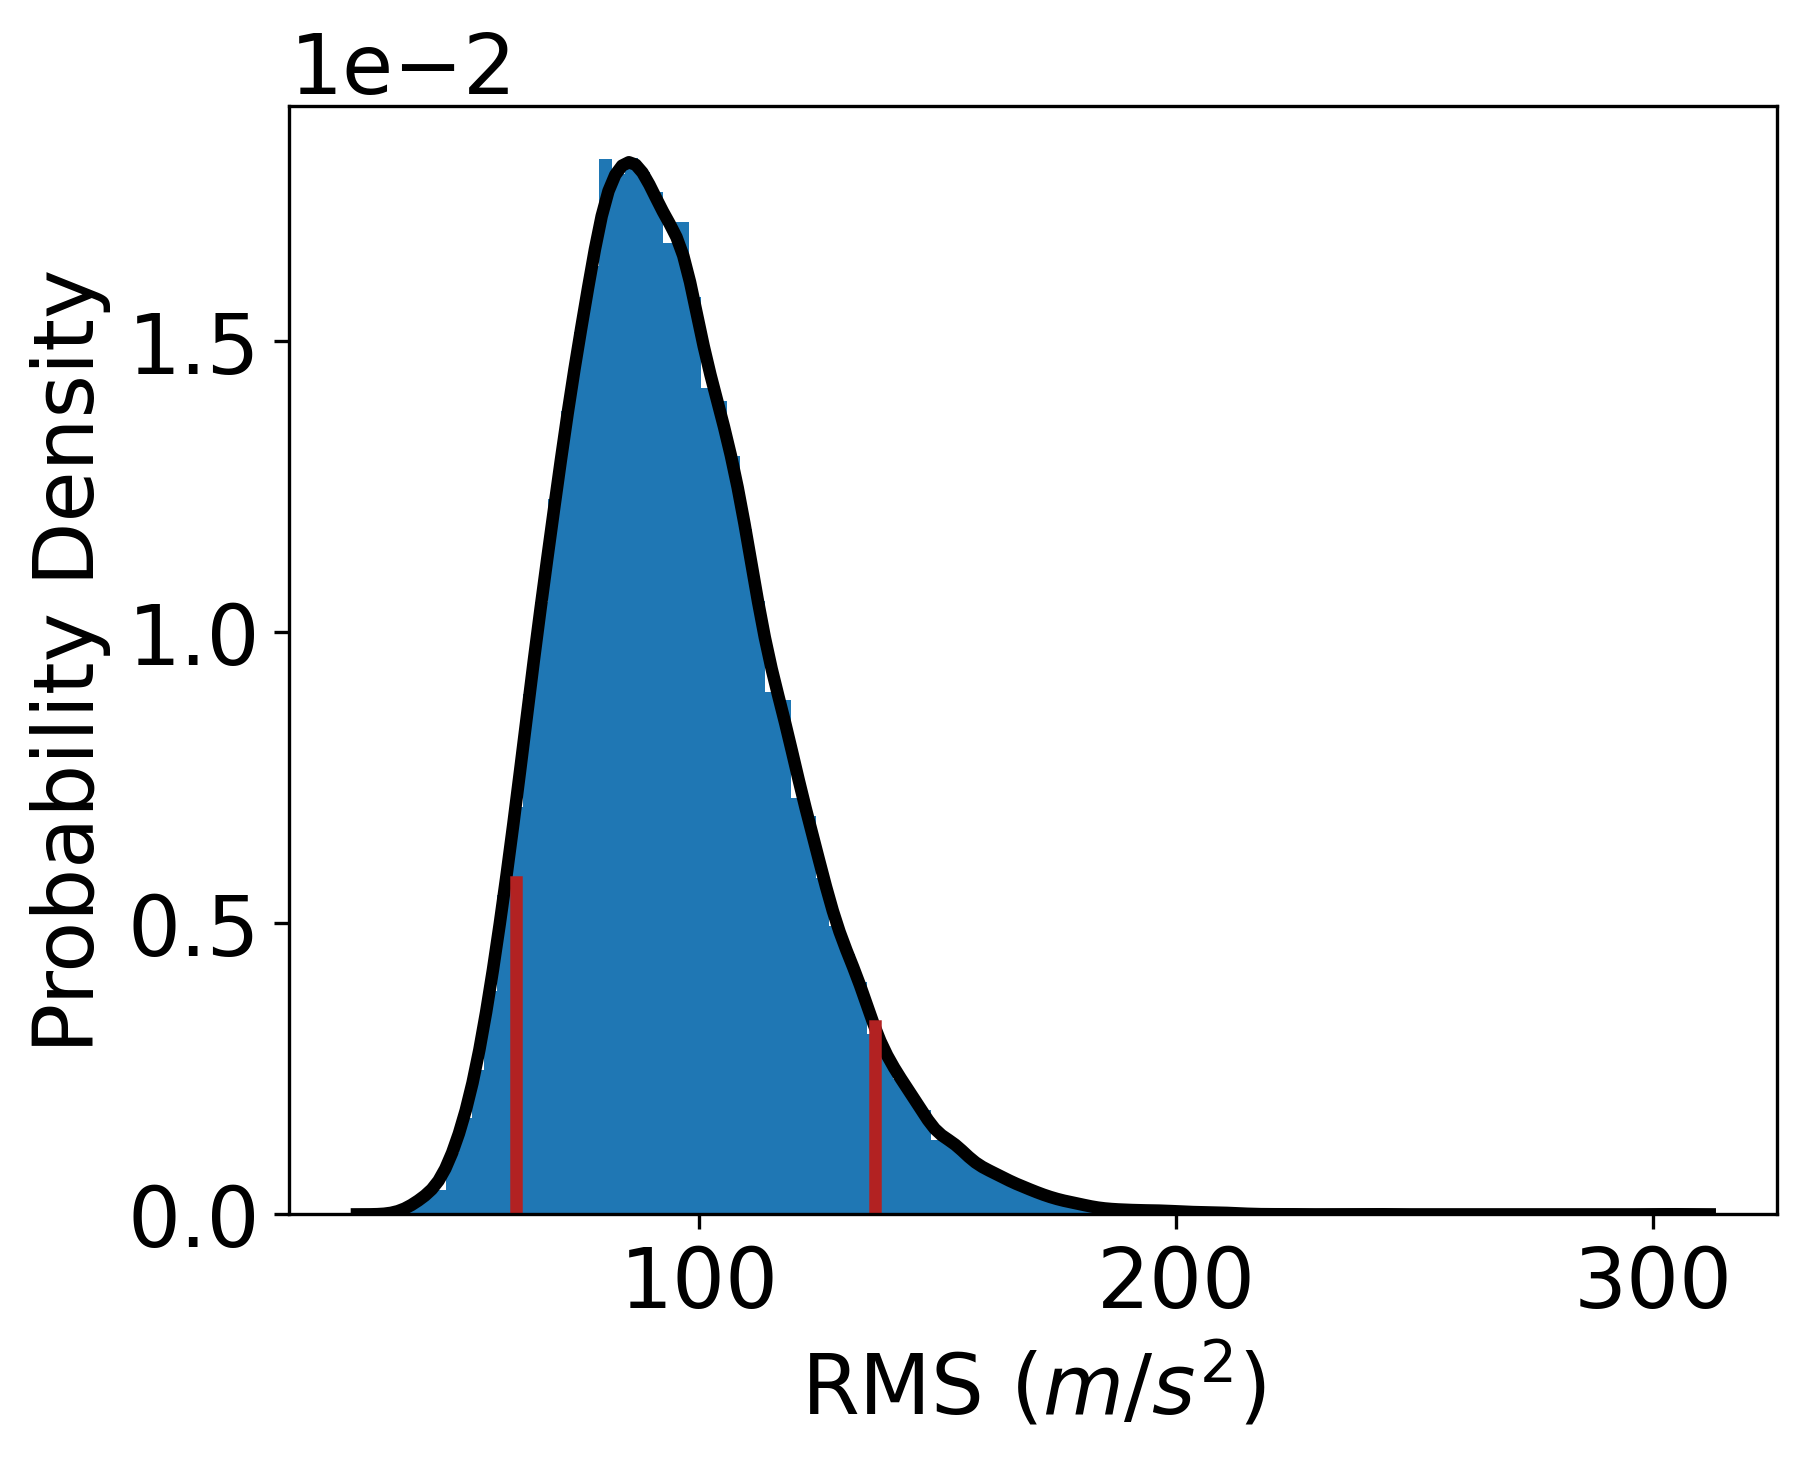

The 95 percentile is = 136.83 and the 5 percentile is = 61.57 and the median is = 92.04


In [4]:
# plot the histogram of the RMS values and kde plot and compute 95 and 5 percentile
import seaborn as sns
RMS_list = np.array(RMS_list)
plt.hist(RMS_list,bins=100,density=True)
sns.kdeplot(RMS_list,linewidth=3,color='black',label='KDE')
plt.xlabel('RMS $(m/s^2)$')
plt.ylabel('Probability Density')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
rms_95 = np.percentile(RMS_list,95)
rms_5 = np.percentile(RMS_list,5)
rms_median = np.percentile(RMS_list,50)

plt.axvline(rms_95,linewidth=3,ymax=0.17,color='firebrick',label='95 percentile')
plt.axvline(rms_5,linewidth=3,ymax=0.3,color='firebrick',label='5 percentile')

plt.savefig('RMS_histogram.png',bbox_inches='tight')
plt.show()




print(f'The 95 percentile is = {rms_95:.2f} and the 5 percentile is = {rms_5:.2f} and the median is = {rms_median:.2f}')


In [31]:
# load a signal with 95 percentile RMS and plot the PSD
path_generated_dataset = Path(settings.default['path']['abspath']) / Path(settings.default['path']['generated_dataset'])

RMS_list = []
with h5py.File(path_generated_dataset, 'r') as input_file:
    dh = HDF5DataBuilder(input_file)
    dt = dh.get_simulation_dt('POPULATION_1', 'default_simulation')
    iterator = dh.get_data_iterator()
    tdd_95 = None
    tdd_5 = None
    tdd_50 = None
    for d in tqdm(iterator):
        tdd = d['TDD']

        for k, v in tdd.items():
            acc_7 = v[:, 2 * 8 + 1]

            system_name = k
            anomaly_level = d['experiment_params']['anomaly_level']
            state = d['experiment_params']['state']
            latent_value = float(d['experiment_params']['latent_value'])
            fr = d['resonance_frequency_data'][k]
            amplitude = d['experiment_params']['amplitude']
            rms = np.sqrt(np.mean(acc_7**2))
            RMS_list.append(rms)
            if system_name!= 'system_0':
                continue
            
            if np.abs(rms-rms_95)<3 and tdd_95 is None and anomaly_level == '0' and np.abs(latent_value-80 )< 9 :
                print(rms,amplitude)
                tdd_95 = acc_7

            if np.abs(rms-rms_5+20)<3 and tdd_5 is None and anomaly_level == '0'and np.abs(latent_value-80 )< 9:
                print(rms,amplitude)
                tdd_5 = acc_7

            if np.abs(rms-rms_median)<3 and tdd_50 is None and anomaly_level == '0'and np.abs(latent_value-80 )< 9:
                print(rms,amplitude)
                tdd_50 = acc_7
        if tdd_95 is not None and tdd_5 is not None and tdd_50 is not None:
            break

132it [00:03, 40.61it/s]

89.33350335525337 15.596348505063299


2551it [00:58, 41.94it/s]

136.5471229998475 14.568412255739673


2600it [00:59, 43.35it/s]


In [27]:
dt = 0.0025

In [28]:
tdd_5

array([0.00000000e+00, 3.64003440e-09, 2.69093469e-06, ...,
       5.32766684e+01, 4.97869958e+01, 3.02753326e+01])

In [29]:
noise = generate_noise(SNR_dB=30,signal_length=len(tdd_5),RMS_signal=rms_5)
noise_2 = generate_noise(SNR_dB=18,signal_length=len(tdd_95),RMS_signal=rms_5)
noise_3 = generate_noise(SNR_dB=10,signal_length=len(tdd_50),RMS_signal=rms_5)
# plot the PSD of the signal with 5 percentile RMS
f,psd_5=compute_PSD(tdd_5,dt=dt,nperseg=1024)
f,psd_95 = compute_PSD(tdd_95,dt=dt,nperseg=1024)
f,noise_psd=compute_PSD(noise,dt=dt,nperseg=1024)
f,noise_2_psd=compute_PSD(noise_2,dt=dt,nperseg=1024)
f,noise_3_psd=compute_PSD(noise_3,dt=dt,nperseg=1024)
plt.plot(f,psd_95,linewidth=2,label='High RMS')
plt.plot(f,psd_5,linewidth=2,label='Low RMS')
plt.plot(f,noise_psd,label='Noise - 30 dB SNR')
plt.plot(f,noise_2_psd,label='Noise - 18 dB SNR')
#plt.plot(f,noise_3_psd,label='Noise - 10 dB SNR')
plt.margins(x=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD $(g^2/Hz)$')
plt.yscale('log')

plt.legend()
plt.savefig('PSD.png',dpi=300,bbox_inches='tight')
plt.show()

TypeError: object of type 'NoneType' has no len()

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
